## Restructuring Bandits and Agents

What happens if your agent is trying different strategies/policies? To compare do this, I am encapsulating agents under a general class pattern here, where each can have a different form for choosing the next lever to pull.

This is exactly the same as before, just being careful to make sure the access to each of the different agents is the same.

This notebook exists to test out functionality of the different kinds of agents.

First, quickly define a very simple bandit, where the expectation value of the reward for each arm, and the best reward return possible are available as attributes (this is to enable us to calculate the Regret).

In [105]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#basic normal bandit to test the functionality of agents
class Bandit:
    """Class for a simple k-armed bandit without context dependence.
    It includes variable number of arms, initialization reward distribution for
    each arm (hidden from agent) and method to have arm pulled and return reward. """

    def __init__(self, k):
        self.k = k
        self.means = np.random.normal(loc=0, scale=2, size=k) #this is expectation value in this case for each level
        #just to make it explicit:
        self.expected_reward = self.means
        self.stdevs = [1] * k

        self.best_arm = np.argmax(self.means)
        self.best_reward = self.means[self.best_arm]

    def pull_lever(self, lever):
        return np.random.normal(loc=self.means[lever], scale=self.stdevs[lever])


Here I am trying to trim down the fat of the GreedyAgent class used for the toy example, and making it more general. I am reformulating the outputs in terms of regret, as well as the q(s,a). q(s,a) is an updating table of what the expected reward of a particular action is, wheras regret is the difference between that and the ideal case. It is helpful to have access to both. 

Each agent requires the ability to take an action, one at a time, and receive an updated estimate of the action-value function corresponding to that action. I have also included the possibility of updating the regret. 

In [3]:
class eGreedyAgent:
    
    def __init__(self, bandit):
        #only require the bandit to initialise
        
        #general attributes of all agents
        self.bandit = bandit
        self.pull_record = [0] * self.bandit.k
        
        #required to keep track of the agent's knowledge of the probability distributions
        # (actually some are redundant, but useful!)
        self.Q = [0] * self.bandit.k
        #cumulative regret
        self.regret = [0] * self.bandit.k
        #keeping an eye on how regret changes (how well it converges)
        self.regrets_trajectory = [] 
        
    def act(self):
        #the difference here is that the choice of lever is included directly with call to another function
        #and excess monitoring is removed. 
        
        #choose the lever e-greedily
        explore = np.random.rand()
        if explore <= self.epsilon:
            lever = np.random.choice(self.bandit.k)
        else:
            lever = np.argmax(self.Q)

        # Update the array keeping track of how many times each lever has been pulled
        self.pull_record[lever] += 1
        
        #actually get back the reward
        reward = self.bandit.pull_lever(lever)

        # update the q estimate
        self.update_Q(lever, reward)
        
    def update_Q(self, lever, reward):
        self.Q[lever] = self.Q[lever] + (1 / self.n[lever]) * (reward - self.Q[lever])
        
    def update_R(self, reward, lever):
        
        self.regret[lever] += (self.bandit.best_reward - self.reward[lever])
        self.regrets_trajectory.append(self.regret)
        
        
        

This is all very well but it doesn't yet generalise to not just e-greedy action rules. In a high-level abstraction way, what does a general agent need to do? i.e. assuming the action is taken care of in child classes. 

* making choice of lever pulling, pulling it and recording what happens -- child class
* recording the update to the Q and R -- parent class

From dividing tasks up in this way (and it isn't unique) it is clear that the thing that all the child classes need to have in common is the ability to pass back/produce in a uniform way it's latest idea of the Q value and Regret for all levers. This actually amounts to the child class being able to return, based on the reward it finds, the updated Q value, as Regret is derived from that. 

Given access to updated Q, the parent can 'deal' with regret tracking.

Perhaps a better way of thinking about this kind of abstraction is just that the child class is cut down to provide the smallest possible varying unit of functionality -- the trick is just to figure out where exactly the boundary lies. 


With this in mind, let's define a parent class and e-greedy child class. 

(I actually put a whole load of extra functionality back in here compared to above, because I want to be able to diagnose whether my system is working correctly. There is a broader point -- these systems are really hard to debug!)

In [263]:
class StandardAgent:
    
    def __init__(self, bandit):
        #only require the bandit to initialise
        
        #general attributes of all agents
        self.bandit = bandit
        self.pull_record = [0] * self.bandit.k
        self.action_sequence = []
        
        #for keeping track of how the agent learns
        self.num_optimal_pulls = 0
        self.optimal_trajectory = []
        
        #keep track of the agent's knowledge of the probability distributions
        #cumulative regret
        self.total_regret = 0
        #keeping an eye on how regret changes
        self.regrets_trajectory = []
        
    def update_R(self, lever):
        
        self.total_regret += (self.bandit.best_reward - self.bandit.expected_reward[lever])
        self.regrets_trajectory.append(self.total_regret)
        
    def choose_lever(self):
        #in child classes this involves getting back the lever and returning the reward
        raise NotImplementedError('Not a method in this parent class.')
        
    @property
    def Q_values(self):
        raise NotImplementedError('Not a method in this parent class.')
        
    def run_trial(self, n_steps):
        for step in range(n_steps):
            
            lever = self.choose_lever()
            
            # Update the array keeping track of how many times each lever has been pulled
            self.pull_record[lever] += 1
            
            # update whether lever was best
            if lever == self.bandit.best_arm:
                self.num_optimal_pulls += 1
            self.optimal_trajectory.append(self.num_optimal_pulls / np.sum(self.pull_record))
            
            self.action_sequence.append(lever)
            # update the regret 
            self.update_R(lever)
    

In [264]:
class eGreedyAgent(StandardAgent):
    
    def __init__(self, bandit, epsilon = 0.1):
        super(eGreedyAgent, self).__init__(bandit)
        
        self.epsilon = epsilon
        
        self.estimatedQ = [0]*self.bandit.k #initialise as zero
        self.Q_trajectory = []
        
        self.reward = 0
        
    def choose_lever(self):
        
        #choose the lever e-greedily
        explore = np.random.rand()
        if explore <= self.epsilon:
            lever = np.random.choice(self.bandit.k)
        else:
            lever = np.argmax(self.Q_values)
            
        #get the reward from the bandit that corresponds to this
        reward = self.bandit.pull_lever(lever)
        
        self.estimatedQ[lever] += (1 / (self.pull_record[lever]+1)) * (reward - self.estimatedQ[lever])
        
        #self.Q_values = Q_values(reward, lever)
        self.Q_trajectory.append(self.estimatedQ)
        
        return lever
    
    @property
    def Q_values(self):
        #print('getting Q_values')
        return self.estimatedQ


Really basic demonstration of getter and setter property decorators from somewhere on stackoverflow. A lot of the time people are only using getters. 

In [6]:
class DumbClass():
    def __init__(self, p):
        self._ciao = p

    @property
    def ciao(self):
        return self._ciao

    @ciao.setter
    def ciao(self, v):
        self._ciao = v

## Slight aside about use of @property decorator

Which I am only using here to get access to something from a class in a consistent way, and I will extend the functionality.

In [7]:
greeting = DumbClass('Hey!')
print(DumbClass.ciao)
print(greeting.ciao)
greeting.ciao = 'See you!'
print(DumbClass.ciao)
print(greeting.ciao)

Hey!
See you!


Which also nicely illustrates the difference between Classes and their instances: the class is a fixed thing in memory. The instance actually has now a dictionary of attributes. See https://www.programiz.com/python-programming/property

In [8]:
greeting.__dict__

{'_ciao': 'See you!'}

## Testing out the functionality of the classes

This basic check shows that everything is working how it did before with the really simple implementations.

In [265]:
bandit = Bandit(10)
b = eGreedyAgent(bandit)

In [266]:
b.run_trial(10000)

In [267]:
b.estimatedQ

[-2.051900139238991,
 1.571134187568163,
 -0.04948396521624052,
 -1.83269823764842,
 -0.19195914281398938,
 2.992397619305477,
 -2.6645233349742528,
 1.3127238409915845,
 -3.675684428617196,
 0.2093934562841262]

In [268]:
b.Q_values #yay! A working example of a property being used to set up a getter!

[-2.051900139238991,
 1.571134187568163,
 -0.04948396521624052,
 -1.83269823764842,
 -0.19195914281398938,
 2.992397619305477,
 -2.6645233349742528,
 1.3127238409915845,
 -3.675684428617196,
 0.2093934562841262]

In [269]:
b.pull_record

[99, 223, 94, 96, 109, 8968, 111, 121, 90, 89]

In [270]:
b.bandit.best_arm

5

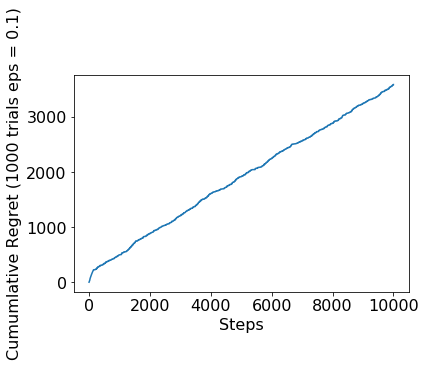

In [271]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(b.regrets_trajectory)
ax.tick_params(labelsize=16)
ax.set_xlabel('Steps', fontsize=16)
ax.set_ylabel('Cumumlative Regret (1000 trials eps = 0.1)', fontsize=16)
plt.show()

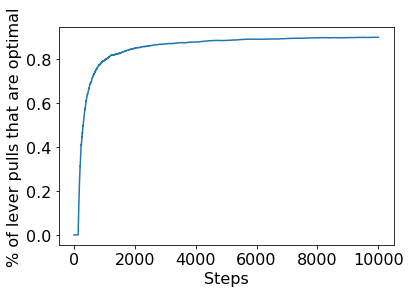

In [272]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(b.optimal_trajectory)
ax.tick_params(labelsize=16)
ax.set_xlabel('Steps', fontsize=16)
ax.set_ylabel('% of lever pulls that are optimal', fontsize=16)
plt.show()

In [ ]:
#b.action_sequence

In [244]:
class explorecommitAgent(StandardAgent):
    
    def __init__(self, bandit, m = 100):
        super(explorecommitAgent, self).__init__(bandit)
        
        self.m = m
        self.tau = 0
        
        self.estimatedQ = [0]*self.bandit.k #initialise as zero
        self.Q_trajectory = []
        
        self.reward = 0
        
    def choose_lever(self):
        
        #sample all levers m times and then start with greedy useage. 
        if self.tau < self.bandit.k * self.m:
            #choose first 'non-complete' lever
            compare = (np.array(self.pull_record) < self.m)
            lever = np.where(compare == True)[0][0]
            print(self.tau)
            print(self.bandit.k*self.m)
            self.tau += 1
        else:
            lever = np.argmax(self.Q_values)
    
        #get the reward from the bandit that corresponds to this
        self.reward = self.bandit.pull_lever(lever)
        
        self.estimatedQ[lever] += (1 / (self.pull_record[lever]+1)) * (self.reward - self.estimatedQ[lever])
        
        #self.Q_values = Q_values(reward, lever)
        self.Q_trajectory.append(self.estimatedQ)
        
        # Update the array keeping track of how many times each lever has been pulled
        self.pull_record[lever] += 1
        
        return lever
    
    @property
    def Q_values(self):
        #print('getting Q_values')
        return self.estimatedQ


In [245]:
c = explorecommitAgent(bandit)

In [246]:
c.run_trial(10000)

0
1000
1
1000
2
1000
3
1000
4
1000
5
1000
6
1000
7
1000
8
1000
9
1000
10
1000
11
1000
12
1000
13
1000
14
1000
15
1000
16
1000
17
1000
18
1000
19
1000
20
1000
21
1000
22
1000
23
1000
24
1000
25
1000
26
1000
27
1000
28
1000
29
1000
30
1000
31
1000
32
1000
33
1000
34
1000
35
1000
36
1000
37
1000
38
1000
39
1000
40
1000
41
1000
42
1000
43
1000
44
1000
45
1000
46
1000
47
1000
48
1000
49
1000
50
1000
51
1000
52
1000
53
1000
54
1000
55
1000
56
1000
57
1000
58
1000
59
1000
60
1000
61
1000
62
1000
63
1000
64
1000
65
1000
66
1000
67
1000
68
1000
69
1000
70
1000
71
1000
72
1000
73
1000
74
1000
75
1000
76
1000
77
1000
78
1000
79
1000
80
1000
81
1000
82
1000
83
1000
84
1000
85
1000
86
1000
87
1000
88
1000
89
1000
90
1000
91
1000
92
1000
93
1000
94
1000
95
1000
96
1000
97
1000
98
1000
99
1000
100
1000
101
1000
102
1000
103
1000
104
1000
105
1000
106
1000
107
1000
108
1000
109
1000
110
1000
111
1000
112
1000
113
1000
114
1000
115
1000
116
1000
117
1000
118
1000
119
1000
120
1000
121
1000
122
1000
123

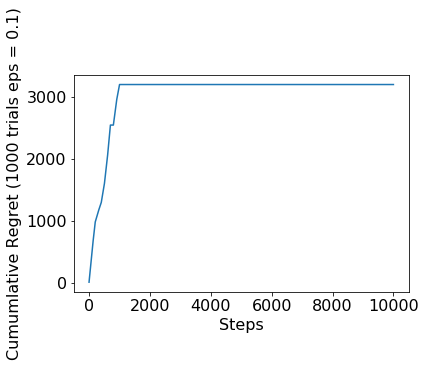

In [247]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(c.regrets_trajectory)
ax.tick_params(labelsize=16)
ax.set_xlabel('Steps', fontsize=16)
ax.set_ylabel('Cumumlative Regret (1000 trials eps = 0.1)', fontsize=16)
plt.show()

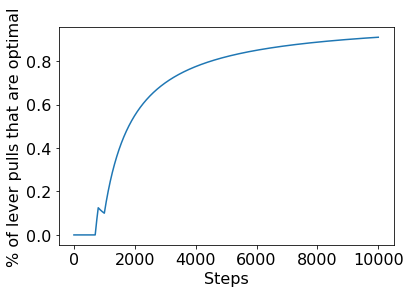

In [248]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(c.optimal_trajectory)
ax.tick_params(labelsize=16)
ax.set_xlabel('Steps', fontsize=16)
ax.set_ylabel('% of lever pulls that are optimal', fontsize=16)
plt.show()

Time to add an Upper Confidence Bound agent. These are a little different in that they require one to keep track of the UCB variable instead of just the current empirical estimate of the reward mean for each arm. They are parameterised by $\delta$, which is (in a somewhat convoluted rough explanation) the upper bound on the probability of the UCB being an underestimate of the true mean. In other words, keep them small and UCB is likely an overestimate, which is good because then the learner should arrive at the optimal solution with sublinear regret. 

In [273]:
class UCBAgent(StandardAgent):
    
    def __init__(self, bandit, delta = 0.01):
        super(UCBAgent, self).__init__(bandit)
        
        self.delta = delta
        
        self.estimatedQ = [self.bandit.pull_lever(k) for k in range(0, self.bandit.k)]#initialise with single pull
        self.Q_trajectory = []
        
        self.reward = 0
        
        #must introduce a new, child-specific, concept: the UCB
        #UCB initialised as Q with upper bounds
        self.UCB_values = [self.estimatedQ[k] + math.sqrt((2*math.log(1/self.delta))) for k in range(0,self.bandit.k)]
        
    def choose_lever(self):
        
        #pick the lever with the highest UCB 
        lever = np.argmax(self.UCB_values)
    
        #get the reward from the bandit that corresponds to this
        self.reward = self.bandit.pull_lever(lever)
        
        self.pull_record[lever] += 1
        
        #update the UCB for the pulled lever, so that correct UCB's used in next round.
        self.update_UCB(lever)
        
        self.estimatedQ[lever] += (1 / (self.pull_record[lever]+1)) * (self.reward - self.estimatedQ[lever])
        
        #self.Q_values = Q_values(reward, lever)
        self.Q_trajectory.append(self.estimatedQ)
        
        
        return lever
    
    def update_UCB(self, lever):
        #make a calculation of the UCB for the updated lever according to the standard definition
        
        for l in range(0, self.bandit.k):
            if self.pull_record[l] != 0:
                self.UCB_values[l] = self.estimatedQ[l] + math.sqrt((2*math.log(1/self.delta))/(self.pull_record[l]+1))
            else:
                pass
        
    
    @property
    def Q_values(self):
        #print('getting Q_values')
        return self.estimatedQ


In [274]:
ucb = UCBAgent(bandit)

In [275]:
ucb.run_trial(100)

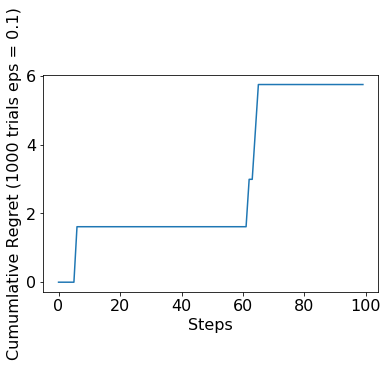

In [276]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ucb.regrets_trajectory)
ax.tick_params(labelsize=16)
ax.set_xlabel('Steps', fontsize=16)
ax.set_ylabel('Cumumlative Regret (1000 trials eps = 0.1)', fontsize=16)
plt.show()

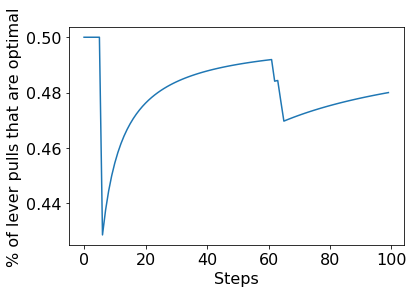

In [277]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ucb.optimal_trajectory)
ax.tick_params(labelsize=16)
ax.set_xlabel('Steps', fontsize=16)
ax.set_ylabel('% of lever pulls that are optimal', fontsize=16)
plt.show()

In [278]:
ucb.pull_record

[0, 6, 0, 0, 0, 192, 0, 2, 0, 0]

In [279]:
ucb.bandit.best_arm

5

Try changing $\delta$ -- it should look like 1/n.

In [280]:
T = 10000 #define horizon
delta = 1/T

In [281]:
ucb = UCBAgent(bandit, delta = delta)

In [282]:
ucb.run_trial(T)

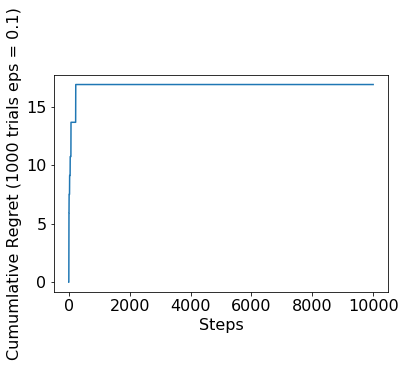

In [283]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ucb.regrets_trajectory)
ax.tick_params(labelsize=16)
ax.set_xlabel('Steps', fontsize=16)
ax.set_ylabel('Cumumlative Regret (1000 trials eps = 0.1)', fontsize=16)
plt.show()

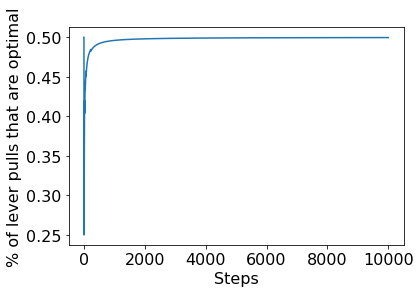

In [284]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ucb.optimal_trajectory)
ax.tick_params(labelsize=16)
ax.set_xlabel('Steps', fontsize=16)
ax.set_ylabel('% of lever pulls that are optimal', fontsize=16)
plt.show()

In [285]:
ucb.pull_record

[0, 2, 2, 0, 2, 19984, 0, 8, 0, 2]

In [286]:
ucb.bandit.best_arm

5

Alright, that's working, modulo a silly error in the percentage calculation.

### Thompson Sampling

This type of sampling involves using a prior on the mean/expected payout of each of the arms that is known to the user/agent. A draw is taken from that prior and this is used to select the best arm to sample. 

Said arm is tried and the reward recorded. This data is used (by p(data|parameters of arm)xp(that value of parameter)) to update the posterior distribution over the parameter representing that arm p(paramters|data). 

In other words, we are performing Bayesian inference over model parameters, but doing so in a way that is biased towards updating the knowledge of higher-payout distributions. This has been shown to be the most effective (slowest regret growth) sampling strategy. 

IN order to do this, we need to know how to update the posterior distribution of our parameters for each arm's reward distribution. This was very simple for the Bernoulli distribution, and here we add a log normal distribution

In [ ]:
class ThompsonAgent(StandardAgent):
    
    def __init__(self, bandit, theta = 0, sigma = 100):
        super(ThompsonAgent, self).__init__(bandit)
        
        self.hypertheta = theta #the prior distribution over the values of theta for all arm.
        self.hypersigma = sigma
        
        #draw initial values of theta to initialise prior distributions
        self.estimated_theta = [np.random.normal(self.hypertheta, self.hypersigma, 1) for k in range(0, self.bandit.k)]
        
        self.estimatedQ = self.estimated_theta #initialise to look like the random guess for theta
        self.Q_trajectory = []
        
        self.reward = 0
        
    def choose_lever(self):
        
        #pick the lever with the highest expected return based on the prior
        lever = np.argmax(self.estimated_theta)
    
        #get the reward from the bandit that corresponds to this
        self.reward = self.bandit.pull_lever(lever)
        
        self.pull_record[lever] += 1
        
        #update the values of the posterior over the value of theta
        self.update_posterior(lever)
        
        self.estimatedQ[lever] += (1 / (self.pull_record[lever]+1)) * (self.reward - self.estimatedQ[lever])
        
        #self.Q_values = Q_values(reward, lever)
        self.Q_trajectory.append(self.estimatedQ)
        
        
        return lever
    
    def update_posterior(self, lever):
        #make a calculation of the UCB for the updated lever according to the standard definition
        
        self.estimated_theta[lever] = 
        
    
    @property
    def Q_values(self):
        #print('getting Q_values')
        return self.estimatedQ
